In [1]:
%pip install fastai -Uqq

Note: you may need to restart the kernel to use updated packages.


## Step 1: Download images of birds and non-birds¶

In [1]:
from fastcore.all import *
import time

def search_images(term, max_images=200):
    url = 'https://duckduckgo.com/'
    res = urlread(url,data={'q':term})
    searchObj = re.search(r'vqd=([\d-]+)\&', res)
    requestUrl = url + 'i.js'
    params = dict(l='us-en', o='json', q=term, vqd=searchObj.group(1), f=',,,', p='1', v7exp='a')
    urls,data = set(),{'next':1}
    while len(urls)<max_images and 'next' in data:
        data = urljson(requestUrl,data=params)
        urls.update(L(data['results']).itemgot('image'))
        requestUrl = url + data['next']
        time.sleep(0.2)
    return L(urls)[:max_images]

In [2]:
urls = search_images('bird photos', max_images=1)
urls[0]

'http://dreamicus.com/data/bird/bird-05.jpg'

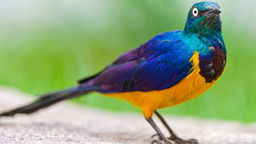

In [3]:
from fastdownload import download_url
dest = 'bird.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

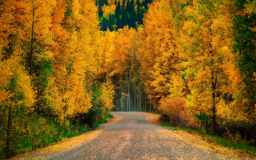

In [4]:
download_url(search_images('forest photos', max_images=1)[0], 'forest.jpg', show_progress=False)
Image.open('forest.jpg').to_thumb(256,256)

In [5]:
searches = 'forest','bird'
path = Path('bird_or_not')

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    resize_images(path/o, max_size=400, dest=path/o)

## Step 2: Train our model

In [9]:
failed = verify_images(get_image_files(path))

In [10]:
failed.map(Path.unlink);len(failed)

2

In [3]:
from fastai.vision.all import *
from fastcore.all import *

path = Path('bird_or_not')
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42), get_y=parent_label, 
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path)

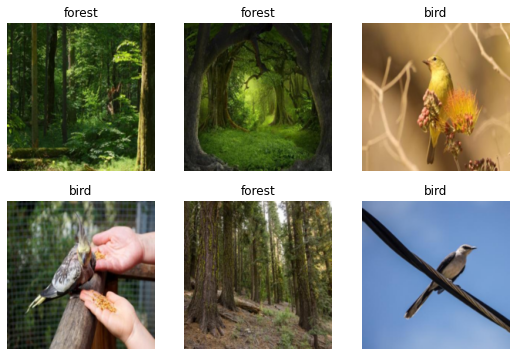

In [12]:
dls.show_batch(max_n=6)

In [13]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/studio-lab-user/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,0.479873,2.065433,0.360000,00:02


epoch,train_loss,valid_loss,error_rate,time
0,0.041954,0.197788,0.080000,00:01
1,0.024736,0.045450,0.013333,00:01
2,0.016017,0.021806,0.013333,00:01


In [19]:
#%pip install timm -Uqq

Note: you may need to restart the kernel to use updated packages.


In [6]:
# Alternatively we can use timm https://rwightman.github.io/pytorch-image-models 
# by passing tthe model name in str 
# Prerequisite: pip install timm
# Also read https://blog.problemsolversguild.com/fastai/technical/exploration/2022/05/02/zero_init_last_resnet18_performance.html
timm_learn = vision_learner(dls, 'resnet18', metrics=error_rate)

In [17]:
timm_learn.model[0].model.conv1

Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

In [20]:
timm_learn.model[0].model.layer1

Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act2): ReLU(inplace=True)
  )
  (1): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act2): ReLU(inplace=True)
  )
)

In [21]:
timm_learn.model[0].model.layer1[0].bn2.weight

Parameter containing:
tensor([0.2496, 0.2198, 0.2756, 0.6073, 0.2654, 0.2942, 0.1136, 0.4425, 0.2868,
        0.2974, 0.2506, 0.4103, 0.4855, 0.3383, 0.4670, 0.1772, 0.2171, 0.5025,
        0.2263, 0.3667, 0.4867, 0.4586, 0.4652, 0.2200, 0.1510, 0.2761, 0.3813,
        0.2803, 0.2382, 0.3953, 0.3032, 0.3163, 0.2025, 0.2323, 0.2003, 0.1661,
        0.4690, 0.3476, 0.3414, 0.2274, 0.2485, 0.2356, 0.2726, 0.4657, 0.3429,
        0.2465, 0.4674, 0.2812, 0.6241, 0.4152, 0.3403, 0.4218, 0.1152, 0.2985,
        0.5802, 0.2795, 0.4706, 0.4517, 0.4303, 0.2749, 0.3427, 0.1137, 0.5069,
        0.4370], device='cuda:0', requires_grad=True)

## Step 3: Use our model

In [14]:
is_bird,_,probs = learn.predict(PILImage.create('bird.jpg'))

In [15]:
print(f'This is a: {is_bird}')
print(f'Probability its a bird: {probs[0]: .4f}')

This is a: bird
Probability its a bird:  0.9998


In [16]:
is_bird,_,probs = learn.predict(PILImage.create('forest.jpg'))
print(f'This is a: {is_bird}')
print(f'Probability its a bird: {probs[0]: .4f}')

This is a: forest
Probability its a bird:  0.0001
